In [26]:
## MSET
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import joblib
import pickle
from scipy import linalg # covaraince sclaer

def bootstrap_limit(stat, alpha=0.05, bootstrap=100, upper = True):
    '''
        @Description
            Bootstrap sampling을 활용한 Control Limit 산출 기법

        @Parameter
            stat : 통계량 (정상상태의 데이터 입력)
            alpha : Control Limit을 정하기 위한 유의수준 (0~1)
            bootstrap : 샘플링 횟수
        @Return
            limit : 임계값 (CL : Control Limit)
    '''
    
    alpha = alpha * 100
    if(upper) : alpha = 100 - alpha
    samsize = max(100, len(stat))
    
    stat = stat.reshape(len(stat)) # 2차원 array를 1차원 array로 변환
    
    # bootstrap 수 만큼 다음 작업을 반복 : samsize(최소 10000번)만큼 정상상태 데이터를 유의수준 만큼 복원 추출 후 평균 값 사용 
    limit = np.mean(list(map(lambda x:np.percentile(np.random.choice(stat,samsize,replace=True),alpha), range(0,bootstrap))))
    
    return limit

def L2norm(stat):
    return(np.sqrt(stat**2))

def matrix_inv(matrix):
    return linalg.pinv(matrix,cond=1.490116e-08)

class msetLR_covariance_scaler() :
    
    def __init__(self) :
        
        self.cov_inv_matrix = None
            
    def fit(self, trdat):
        
        cov_mat = np.cov(trdat.transpose())
        self.cov_inv_matrix = matrix_inv(cov_mat)
        
    def transform(self, tsdat) :
        if isinstance(tsdat, list) :
            tsdat = np.array(tsdat).transpose()
            
        scaled_residual = np.dot(np.array(tsdat), self.cov_inv_matrix)
        return scaled_residual
    
class mset_regress() :
    
    def __init__(self) :
        self.hat_array = None # model이 되는 hat_matrix 저장
        self.UCL = None
        self.LCL = None
        self.varucl = []
        self.varlcl = []
        self.cov_scaler = msetLR_covariance_scaler()
    
    def fit(self, trdat, alpha = 0.05) :
        """

        Parameters
        ----------
        trdat : array
            학습 데이터
        alpha : float, 0~1, default = 0.05
            Control limit의 유의 수준
        Returns
        -------
        trScore : array
            Mset Linearregresion의 Train 잔차 (이상감지 통계량)

        """
        train_intercept = np.ones((trdat.shape[0],1))    
        y_hat_tr = np.zeros((trdat.shape[0], trdat.shape[1]))
        self.hat_array = np.zeros((len(trdat.columns), len(trdat.columns)))

        for i in range(len(trdat.columns)) :
            trainX = np.concatenate((train_intercept, np.delete(trdat.values,i,axis=1)), axis=1)
            trainY = trdat.values[:,i]
            
            self.hat_array[i] = np.linalg.pinv(trainX.transpose() @ trainX) @ trainX.transpose() @ trainY
            y_hat_tr[:,i] = trainX @ self.hat_array[i]            
            
        # 각 변수 별 Trscore
        varTrScore =  trdat.values - y_hat_tr
        
        # Trscore rowsum
        self.cov_scaler.fit(trdat) # cov scaler 학습
        scaled_varTrScore = self.cov_scaler.transform(varTrScore) # 변환
        trScore = L2norm(scaled_varTrScore).sum(axis = 1) # L2norm
        
        ## CL
        # 각 변수 별 CL
        for i in range(trdat.shape[1]) :
            
            self.varucl.append(bootstrap_limit(scaled_varTrScore[:, i], alpha=alpha/2))
            self.varlcl.append(bootstrap_limit(scaled_varTrScore[:, i], alpha=alpha/2, upper=False))
        
        # 합산 CL
        self.UCL = bootstrap_limit(trScore, alpha = alpha)
        self.LCL = self.UCL
    
        return {'trScore' : trScore, 'varTrScore' : scaled_varTrScore}
    
    def CL_printor(self) :
        """
        
        Returns
        -------
        UCL, LCL: float
            upper, lower Control Limit,
        varUCL, varLCL :
            변수 별  UCL, LCL
            
        """
        
        return {'UCL' : self.UCL, 'LCL' : self.LCL, 'varUCL' : self.varucl, 'varLCL' : self.varlcl}
    
    def predict(self, tsdat) :
        """

        Parameters
        ----------
        tsdat : array
            예측 데이터

        Returns
        -------
        tsScore : array
            Mset RandomForest의 Test 잔차 (이상감지 통계량)

        """
        if isinstance(tsdat, pd.DataFrame) :
            tsdat = tsdat.values
            delete_axis = 1
        if isinstance(tsdat, pd.core.series.Series) :
            tsdat = tsdat.values
            
        if tsdat.ndim == 1 :
            num_rows, num_columns = tsdat.shape[0], 1
            delete_axis = None
            test_intercept = np.ones((1))
           
            # 변수 별 연산
            y_hat_ts = np.zeros((num_rows))
            for i in range(tsdat.shape[1]):
                testX = np.concatenate((test_intercept, np.delete(tsdat,i,axis=delete_axis)), axis=delete_axis)
                y_hat_ts[i] = testX @ self.hat_array[i]
        
               # Row Sum
                varTsScore =  tsdat - y_hat_ts
                scaled_varTsScore = self.cov_scaler.transform(varTsScore) # 변환
                tsScore = L2norm(scaled_varTsScore).sum(axis = 0) # L2norm

        # tsdat.dim != 1
        else :
            num_rows, num_columns = tsdat.shape[0], tsdat.shape[1]
            delete_axis = 1
            test_intercept = np.ones((num_rows,1))

            # 변수 별 연산 
            y_hat_ts = np.zeros((num_rows, num_columns))
            for i in range(tsdat.shape[1]) :
                testX = np.concatenate((test_intercept, np.delete(tsdat,i,axis=delete_axis)), axis=delete_axis)
                y_hat_ts[:,i] = testX @ self.hat_array[:,i]

            # Row Sum                
            varTsScore =  tsdat - y_hat_ts
            scaled_varTsScore = self.cov_scaler.transform(varTsScore) # 변환
            tsScore = L2norm(scaled_varTsScore).sum(axis = 1) # L2norm
            
        return {'tsScore' : tsScore, 'varTsScore' : scaled_varTsScore}
    
def mset_LinearRegression(trdat, tsdat, alpha = 0.05) :
    
    model = mset_regress()
    fit = model.fit(trdat, alpha)
    CL = model.CL_printor()
    pred = model.predict(tsdat)
    
    # model pickle 저장
    # saved_model = joblib.dump(model, 'mset_LR.pkl')
    
    return {'trScore' : fit['trScore'], 'tsScore' : pred['tsScore'], 'UCL' : CL['UCL'], 'LCL' : CL['LCL'],
            'varTrScore' : fit['varTrScore'], 'varTsScore' : pred['varTsScore'], 'varUCL' : CL['varUCL'], 'varLCL' : CL['varLCL']}

In [27]:
df = pd.read_csv('./data/shot6_3D365-48910.csv', encoding='euc-kr')

In [28]:
labels = df['판정코드']

In [29]:
labels.value_counts()

0    6885
1       8
Name: 판정코드, dtype: int64

In [30]:
# train 정상, test 정상
in_train, in_test = train_test_split(df.loc[labels == 0], test_size=0.3, shuffle=False)

In [31]:
# test 이상
out_test = df[labels == 1]

# test
test = pd.concat([in_test, out_test], axis=0)

In [32]:
test['판정코드'].value_counts()

0    2066
1       8
Name: 판정코드, dtype: int64

In [33]:
model = mset_LinearRegression(in_train.iloc[:,2:], test.iloc[:,2:], alpha=0.05)

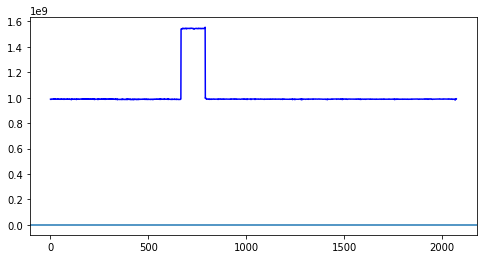

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(model['tsScore'], color='blue')
plt.axhline(y = model['UCL'])
plt.show()

In [40]:
# train 정상, test 정상
in_train, in_test = train_test_split(df.values[labels == 0, 2:33], test_size=0.3, shuffle=False)

# test 이상
out_test = df.values[labels == 1, 2:33]

# test
test = np.concatenate([in_test, out_test], axis=0)

model2 = tsquare(in_train, test, alpha=0.05)

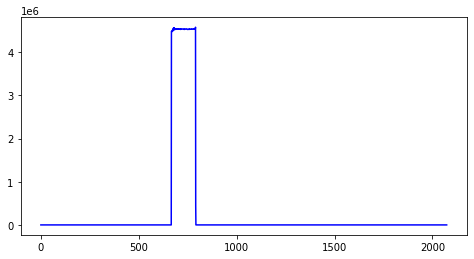

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(model2['tsScore'], color='blue')
# plt.axhline(y = model['CL'], color='red')
plt.show()

In [48]:
# index : 0~32 실제 값
# index : 33~ 세팅 값

In [45]:
model['CL']

48.42177209055219

In [47]:
model2['CL']

46.43647731401474